<img src="https://bonsai-producciones.com/wp-content/uploads/2020/04/logo-CUNEF.png" width="400" height="200">

# <p style="text-align:center"> <font color='darkorange'>**FINAL_ST_HW - TOSCOS**</font>
### <p style="text-align:center"> **Técnicas de predicción: series temporales**</strong><br />
    
<p style="text-align:center"> <font color='grey'>Mario Sabater Pascual - <u>mario.sabater@cunef.edu </u></font>

## <font color='black'>**Introducción**</font>


En el fichero datos.csv se encuentran las ventas (Sales) de las diez tiendas de la cadena de supermercados TOSCOS. Son datos diarios y además de las ventas tiene información sobre el número de clientes que han entrado en cada tienda (Customers), si está abierta (Open), si tienes promociones (Promo), si es fiesta (StateHoliday) y si es día lectivo (SchoolHoliday).

Las tiendas están divididas en 3 zonas (1, 2 y 3) y tienen 3, 3 y 4 tiendas respectivamente.

**En este notebook graficaremos y predeciremos las ventas totales diarias**

 - [Carga de librerías](#0)
 - [Carga y tratamiento de datos](#1)
 - [Gráfica ventas totales diarias](#2)
 - [Predicción ventas totales diarias](#3)
     - [Prophet](#3.1)
         - [Prophet Base con estacionalidades custom](#3.1.1)
         - [Prophet con estacionalidades custom y 1 variable exogena](#3.1.2)
         - [Prophet con estacionalidades custom y varias variables exogenas](#3.1.3)  
     - [Neural Prophet](#3.2)
 - [Mejor Modelo y exportación de los datos](#4)

##  <a name="0"> **Carga de librerías**</a>

In [64]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error, mean_absolute_error
from statsmodels.tsa.seasonal import seasonal_decompose
from sktime.utils.plotting import plot_series
from sktime.transformations.series.boxcox import LogTransformer

import warnings
warnings.filterwarnings('ignore')

##  <a name="1"> **Carga y tratamiento de datos**</a>

In [2]:
datos = pd.read_csv('../data/datos.csv')
datos = datos.sort_values(by=['Date', 'Store'])
datos.head(3)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
9226,T1a,2,2013-01-01,0,0,0,0,a,1
9227,T1b,2,2013-01-01,0,0,0,0,a,1
9228,T1c,2,2013-01-01,0,0,0,0,a,1


In [3]:
#Transformación columna Date.
datos['Date'] = pd.to_datetime(datos['Date'], format=('%Y-%m-%d'))

In [4]:
datos.set_index('Date', inplace=True)

Para graficar los datos totales, debemos sumar las ventas diarias de cada una de las tiendas. Inlcuimos también otras columnas como Customers, Open y Promo porque creemos que en un futuro pueden ser útiles a la hora de predecir.

In [5]:
datos_totales_diarios = datos.groupby('Date')['Sales', 'Customers', 'Open', 'Promo'].sum().reset_index() 
datos_totales_diarios.set_index('Date', inplace=True)
datos_totales_diarios.head()

,Sales,Customers,Open,Promo
Date,,,,
2013-01-01,0,0,0,0
2013-01-02,61926,7490,9,0
2013-01-03,53588,6650,9,0
2013-01-04,56578,6784,9,0
2013-01-05,54938,6747,9,0


In [6]:
datos_totales_diarios['Promo'].unique()

array([ 0, 10,  9])

Observamos que la columna Promo solo tiene valores de 0, 9 y 10. Lo que significa que o ninguna tienda tiene promoción o al menos 9 de las 10 tiendas tienen promoción si no todas. Entendemos que las rebajas aumentan las ventas, por lo que lo incluiremos en nuestro grafico. 

##  <a name="2"> **Gráfica ventas totales diarias**</a>

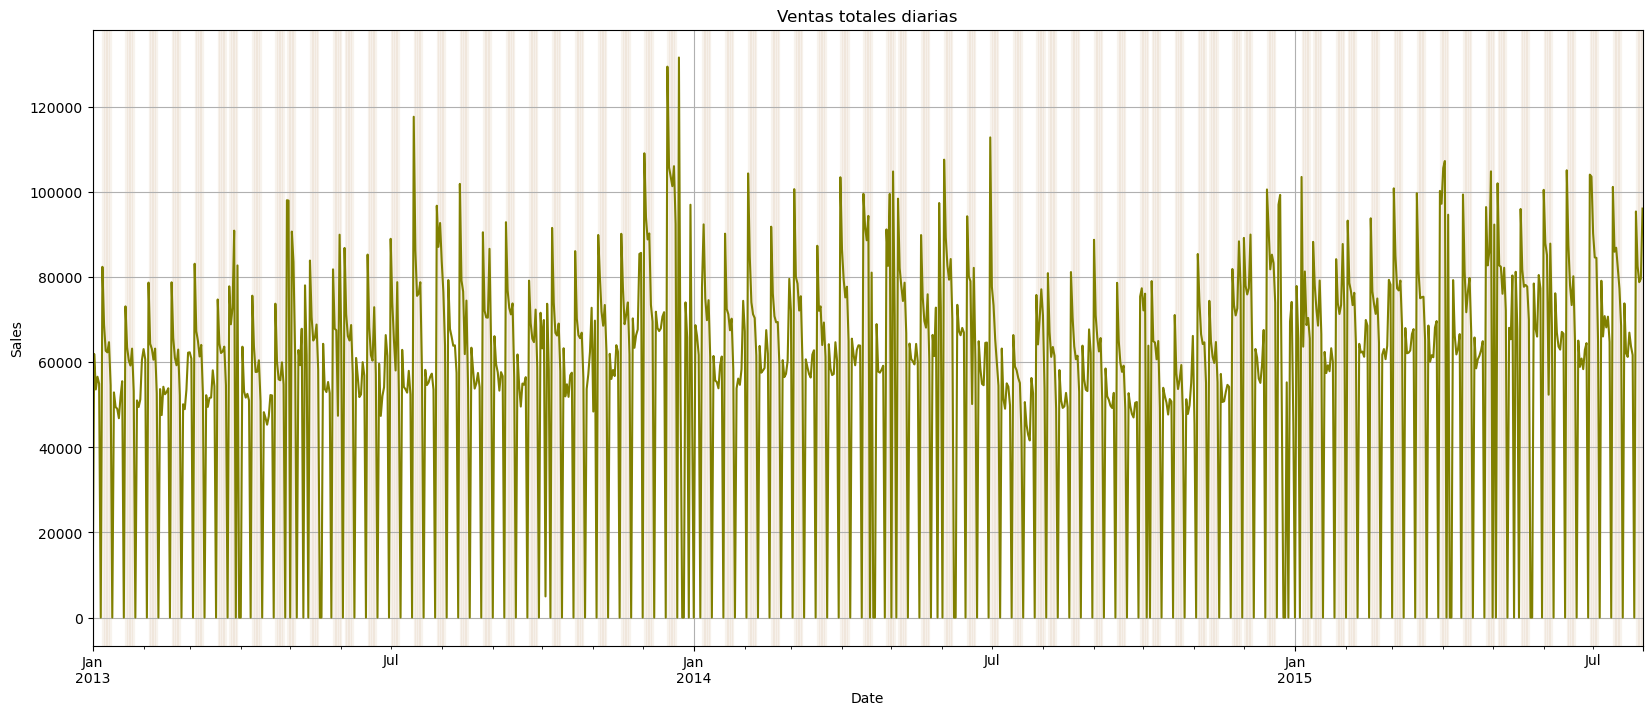

In [59]:
#Creamos una mask para marcar el fondo cuando en al menos 9 tiendas haya rebajas.
mask = datos_totales_diarios['Promo'] >= 9

fig, ax = plt.subplots(figsize=(20,8))
datos_totales_diarios['Sales'].plot(title="Ventas totales diarias", color = 'olive',
                                    grid=True,xlabel="Date", ylabel="Sales", ax=ax)

# create the regions where sales are 9 or more
for index, row in datos_totales_diarios[mask].iterrows():
    ax.axvspan(index, index+pd.Timedelta('1D'), color='tan', alpha=0.1)

plt.show()

Oservamos que los picos de mayor venta coinciden con los días de rebaja. Para observarlo mejor utilizaremos solo los 100 últimos datos

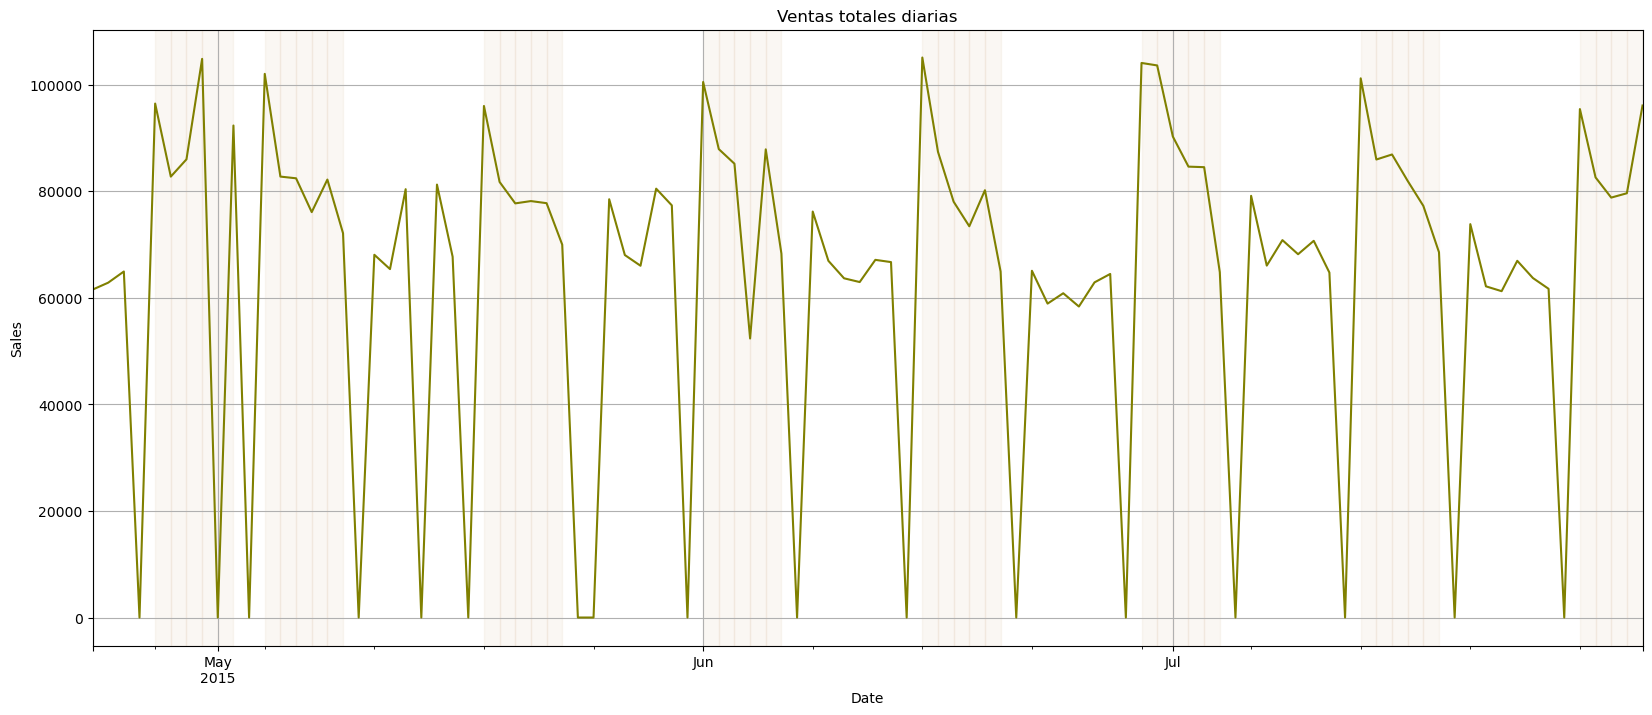

In [61]:
mask = datos_totales_diarios['Promo'] >= 9

fig, ax = plt.subplots(figsize=(20,8))
datos_totales_diarios.tail(100)['Sales'].plot(title="Ventas totales diarias", color = 'olive',
                                    grid=True,xlabel="Date", ylabel="Sales", ax=ax)

# create the regions where sales are 9 or more
for index, row in datos_totales_diarios[mask].tail(100).iterrows():
    ax.axvspan(index, index+pd.Timedelta('1D'), color='tan', alpha=0.1)

plt.show()

**Serie logaritmica de ventas totales diarias**

In [65]:
total_diario = datos_totales_diarios['Sales']
transformer = LogTransformer()
log_total_diario = transformer.fit_transform(total_diario)

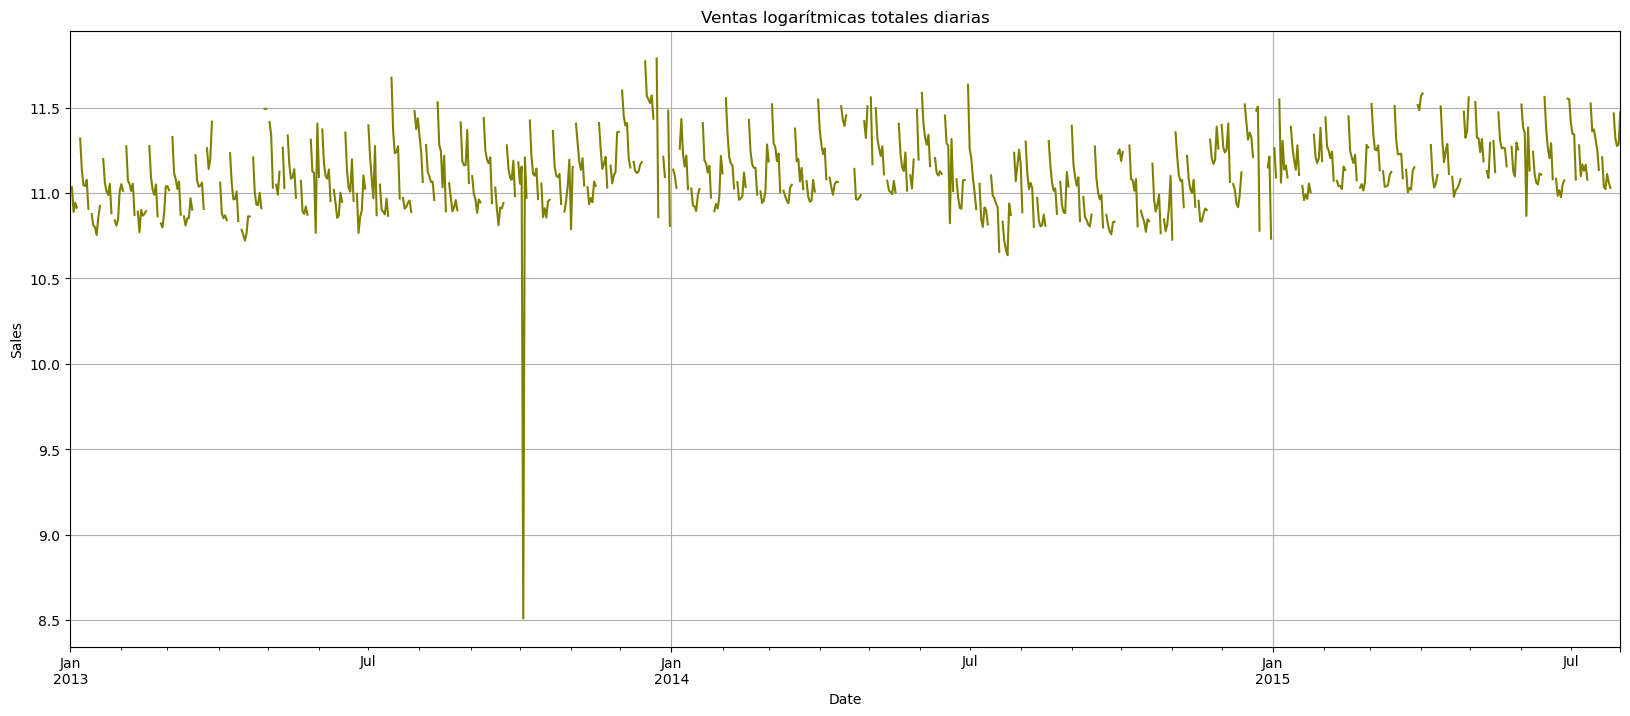

In [67]:
fig, ax = plt.subplots(figsize=(20,8))
log_total_diario.plot(title="Ventas logarítmicas totales diarias", color = 'olive',
                                    grid=True,xlabel="Date", ylabel="Sales", ax=ax)
plt.show()


##  <a name="3"> **Predicción ventas totales diarias**</a>

Nuestro dataset, en esta predicción tiene datos diarios. Además, como acabamos de ver tenemos variable exogenas que afectan a los resultados del modelo (Open, Promo, StateHoliday...). Por este motivo nuestra primera predicción la realizaremos utilizando el algoritmo Prophet.

In [9]:
from prophet import Prophet
from fbprophet.plot import add_changepoints_to_plot
from sklearn.metrics import r2_score

###  <a name="3.1"> **Prophet**</a>

Debido a la longitud del dataset, para evitar overfitting y obtener una mejor predicción, no utilizaremos los datos correspondientes a 2013.

In [10]:
y = datos_totales_diarios['Sales']
y.drop(y.index[:365], inplace=True)
y = y.reset_index(drop=False)
y.columns = ['ds', 'y'] #siempre llamar a la fecha ds (no meterla como index) y a los datos a predecir "y"
y.tail()

,ds,y
572,2015-07-27,95402
573,2015-07-28,82582
574,2015-07-29,78795
575,2015-07-30,79610
576,2015-07-31,96078


Separamos entre train y test, en una relación de 80%-20%.

In [11]:
train = y.iloc[:round(len(y)*0.8),:]
test = y.iloc[round(len(y)*0.8):,:]

####  <a name="3.1.1"> **Prophet Base con estacionalidades custom**</a>

In [12]:
m = Prophet()
m.add_seasonality(name='weekly', period=7, fourier_order=7) 
m.add_seasonality(name='monthly', period=30.5, fourier_order=3) 
#m.add_seasonality(name='quart', period=(365.25/4), fourier_order=5) 
m.add_seasonality(name='yearly', period=365.25, fourier_order=7) 

m.fit(train)

future = m.make_future_dataframe(periods=len(test))
forecast = m.predict(future)
print(r2_score(list(test['y']), list(forecast.loc[round(len(y)*0.8):,'yhat'] )))

INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


0.677092952235457


In [13]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,monthly,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2014-01-01,27013.850704,46156.692908,84589.701330,27013.850704,27013.850704,39159.997974,39159.997974,39159.997974,6520.934472,...,35142.163957,35142.163957,35142.163957,-2503.100455,-2503.100455,-2503.100455,0.0,0.0,0.0,66173.848678
1,2014-01-02,27024.484695,43104.240864,78772.710592,27024.484695,27024.484695,34649.731577,34649.731577,34649.731577,6042.271354,...,31019.295136,31019.295136,31019.295136,-2411.834913,-2411.834913,-2411.834913,0.0,0.0,0.0,61674.216273
2,2014-01-03,27035.118687,48772.438421,84036.716154,27035.118687,27035.118687,38463.882487,38463.882487,38463.882487,5062.509201,...,35676.974300,35676.974300,35676.974300,-2275.601015,-2275.601015,-2275.601015,0.0,0.0,0.0,65499.001173
3,2014-01-04,27045.752678,41605.880384,79585.751821,27045.752678,27045.752678,33762.186712,33762.186712,33762.186712,3673.126215,...,32185.576533,32185.576533,32185.576533,-2096.516036,-2096.516036,-2096.516036,0.0,0.0,0.0,60807.939391
4,2014-01-05,27056.386670,-22141.941420,16424.654346,27056.386670,27056.386670,-29408.221812,-29408.221812,-29408.221812,1989.887731,...,-29520.937743,-29520.937743,-29520.937743,-1877.171801,-1877.171801,-1877.171801,0.0,0.0,0.0,-2351.835143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
572,2015-07-27,31161.649866,43891.150036,81194.564900,31124.351818,31195.841111,32017.795310,32017.795310,32017.795310,-5743.204696,...,45198.251588,45198.251588,45198.251588,-7437.251583,-7437.251583,-7437.251583,0.0,0.0,0.0,63179.445176
573,2015-07-28,31168.810165,40645.581620,78197.078674,31130.961236,31203.624732,28500.325533,28500.325533,28500.325533,-3817.442590,...,39555.925642,39555.925642,39555.925642,-7238.157519,-7238.157519,-7238.157519,0.0,0.0,0.0,59669.135699
574,2015-07-29,31175.970465,39212.412090,76389.791584,31137.544651,31211.393846,26730.267551,26730.267551,26730.267551,-1405.613038,...,35142.163957,35142.163957,35142.163957,-7006.283368,-7006.283368,-7006.283368,0.0,0.0,0.0,57906.238015
575,2015-07-30,31183.130764,37905.145378,75279.617848,31144.086224,31219.223253,25367.788027,25367.788027,25367.788027,1093.442665,...,31019.295136,31019.295136,31019.295136,-6744.949774,-6744.949774,-6744.949774,0.0,0.0,0.0,56550.918791


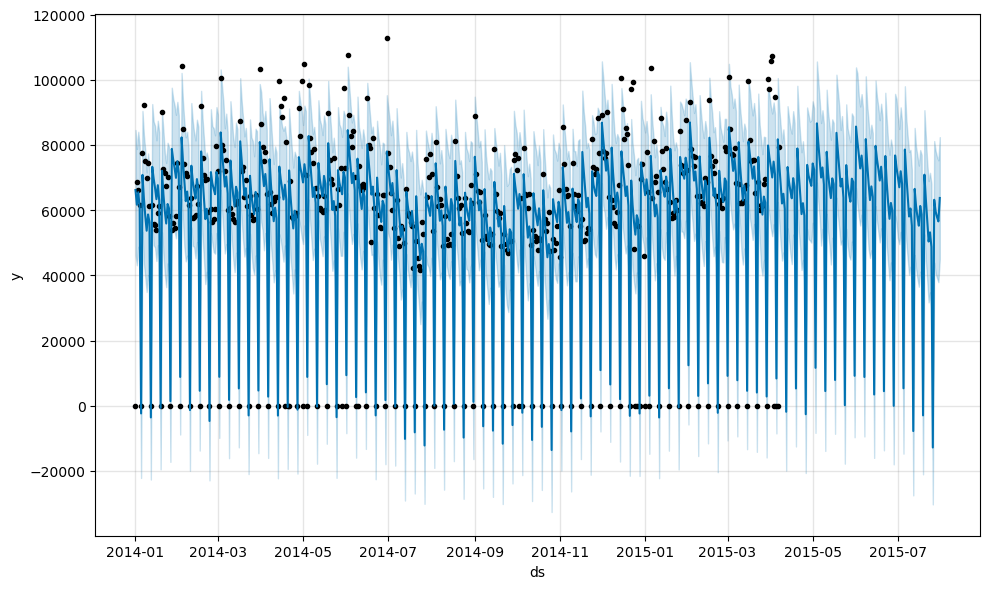

In [14]:
fig1 = m.plot(forecast)
plt.show()

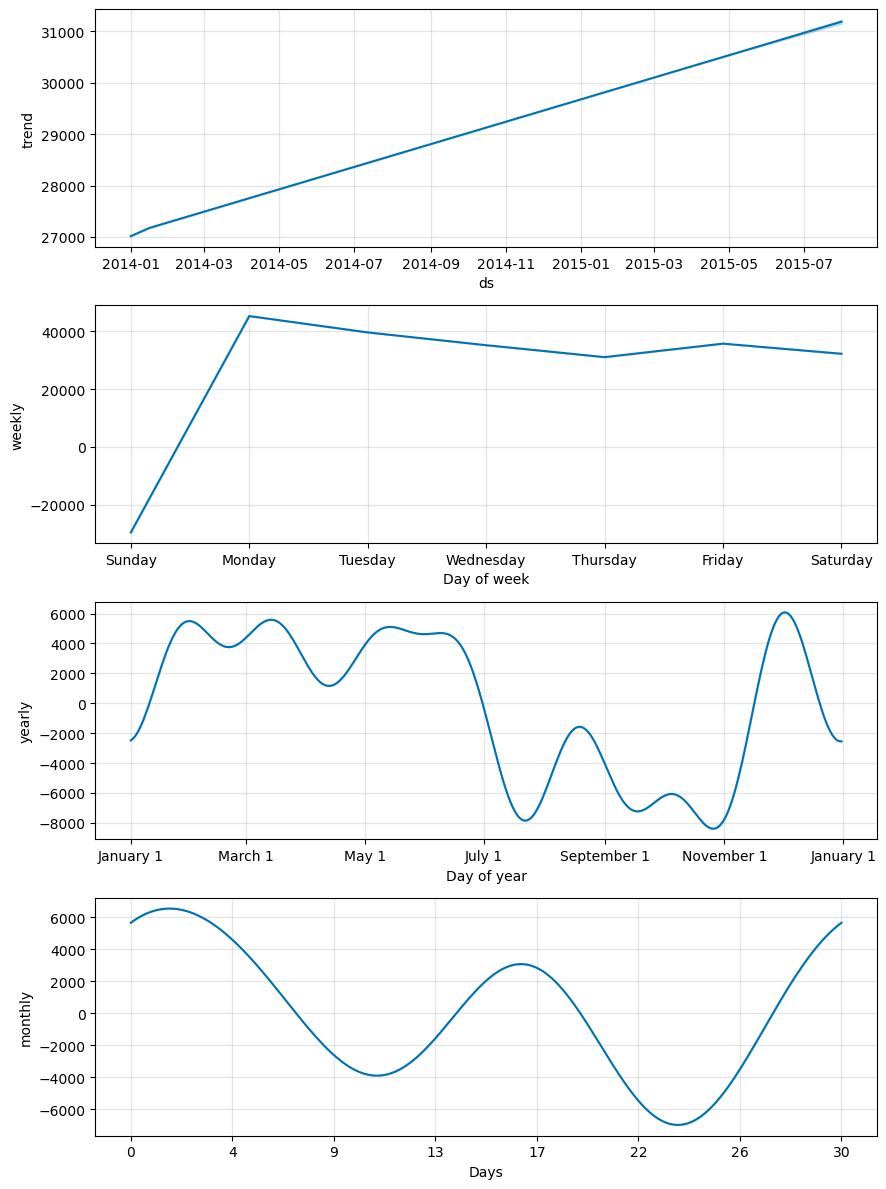

In [15]:
fig2 = m.plot_components(forecast)
plt.show()

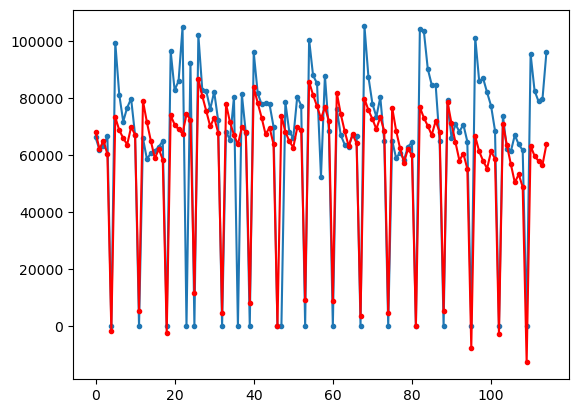

In [16]:
plt.plot(list(test['y']),'.-')
plt.plot(list(forecast.loc[round(len(y)*0.8):,'yhat']),'r.-')
plt.show()

####  <a name="3.1.2"> **Prophet con estacionalidades custom y 1 variable exogena**</a>

**<font color='darkorange'>_Holidays_ Entendidas como Open = 0 <font>**

Modificamos los datos de la columna Open haciendo coincidir los dias closed como "holiday"

In [17]:
closed_shops = pd.read_csv('../data/datos.csv')
closed_shops = closed_shops.sort_values(by=['Date', 'Store'])
closed_shops['Date'] = pd.to_datetime(closed_shops['Date'], format=('%Y-%m-%d'))
closed_shops = closed_shops.groupby('Date')['Open'].sum().reset_index() 
closed_shops.drop(closed_shops.index[:365], inplace=True)
closed_shops= closed_shops.loc[closed_shops['Open'] == 0]
holidays = closed_shops.drop(['Open'], axis=1)
holidays['closed'] = 'holiday'
holidays.columns = ['ds', 'holiday'] 
holidays.head()

,ds,holiday
365,2014-01-01,holiday
369,2014-01-05,holiday
376,2014-01-12,holiday
383,2014-01-19,holiday
390,2014-01-26,holiday


In [18]:
m2 = Prophet(holidays=holidays)
m2.add_seasonality(name='weekly', period=7, fourier_order=9)
m2.add_seasonality(name='monthly', period=30.5, fourier_order=5) 
m2.add_seasonality(name='yearly', period=365.25, fourier_order=9) 

m2.fit(train)

future2 = m2.make_future_dataframe(periods=len(test))
forecast2 = m2.predict(future2)

print(r2_score(list(test['y']), list(forecast2.loc[round(len(y)*0.8):,'yhat'] )))
print(mean_absolute_error(test['y'].values, forecast2['yhat'][round(len(y)*0.8):].values))

INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


0.8322871347240368
9598.402403475595


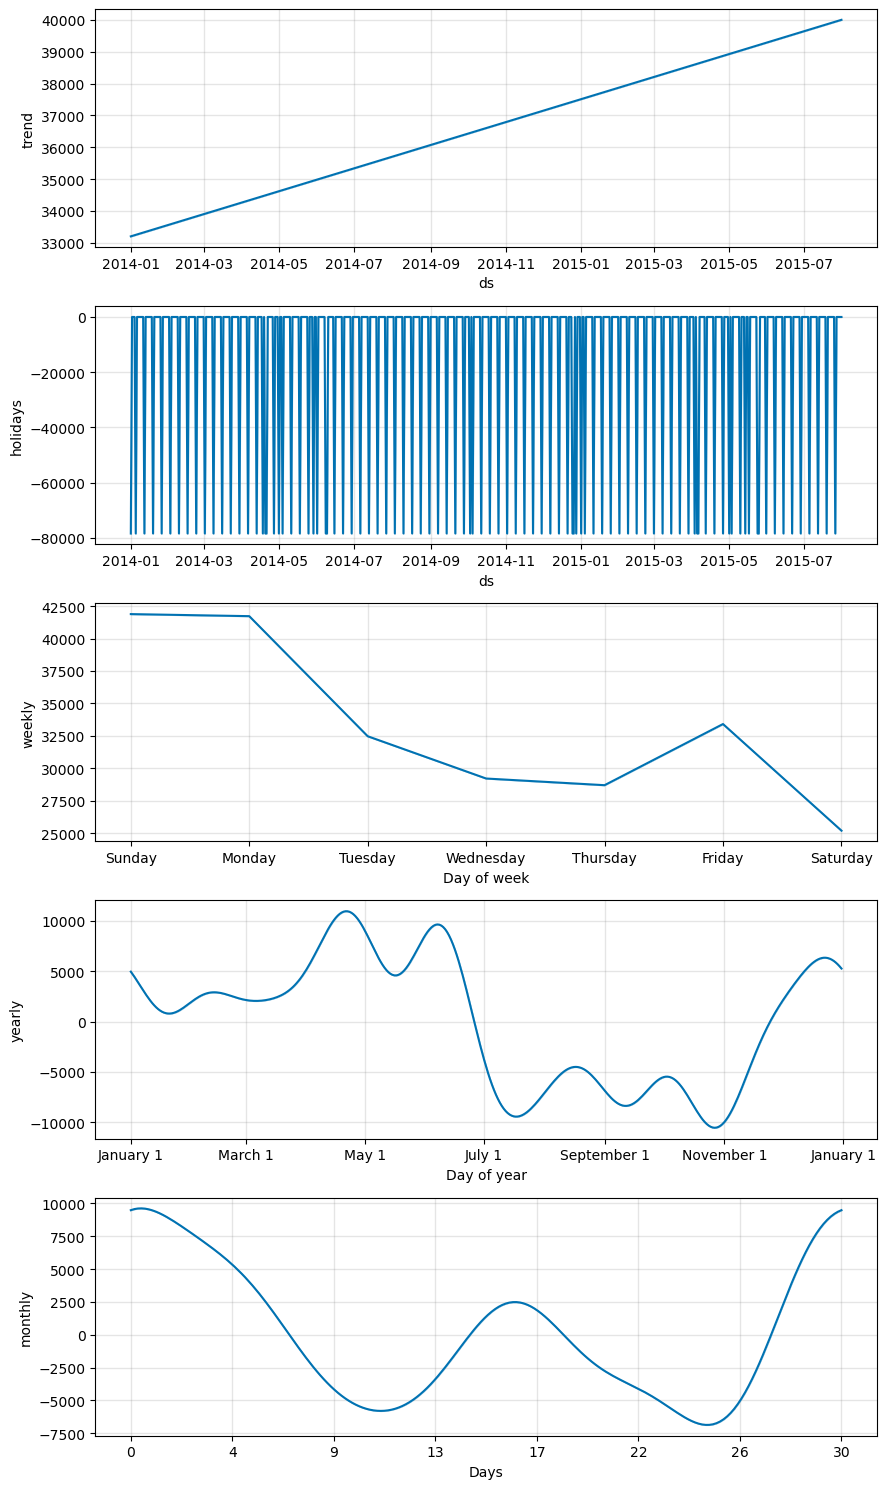

In [19]:
fig2 = m2.plot_components(forecast2)
plt.show()

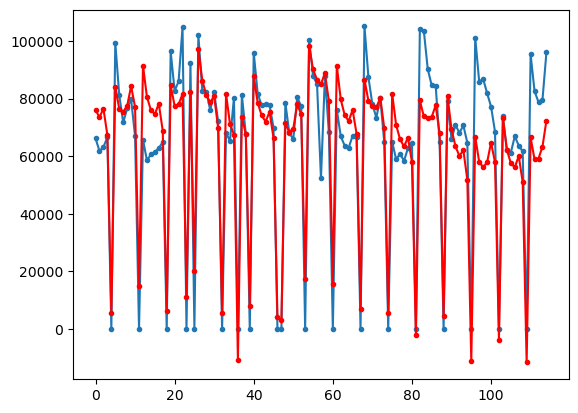

In [20]:
plt.plot(list(test['y']),'.-')
plt.plot(list(forecast2.loc[round(len(y)*0.8):,'yhat']),'r.-')
plt.show()

In [21]:
forecast2.tail(20).T

,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576
ds,2015-07-12 00:00:00,2015-07-13 00:00:00,2015-07-14 00:00:00,2015-07-15 00:00:00,2015-07-16 00:00:00,2015-07-17 00:00:00,2015-07-18 00:00:00,2015-07-19 00:00:00,2015-07-20 00:00:00,2015-07-21 00:00:00,2015-07-22 00:00:00,2015-07-23 00:00:00,2015-07-24 00:00:00,2015-07-25 00:00:00,2015-07-26 00:00:00,2015-07-27 00:00:00,2015-07-28 00:00:00,2015-07-29 00:00:00,2015-07-30 00:00:00,2015-07-31 00:00:00
trend,39776.424143,39788.231651,39800.039159,39811.846667,39823.654175,39835.461683,39847.269191,39859.076699,39870.884207,39882.691715,39894.499223,39906.306731,39918.114239,39929.921747,39941.729255,39953.536763,39965.344271,39977.151779,39988.959287,40000.766795
yhat_lower,-22070.49514,56351.297226,46415.414052,45227.327813,46556.451647,54105.877266,46874.225343,-14833.612278,62042.354011,51715.247927,46103.423101,45664.820818,49578.622298,39654.475441,-22078.911885,55577.253706,47801.282432,48377.258371,51968.004587,61151.816236
yhat_upper,-120.291132,77603.016206,68980.35053,67541.849082,68771.214132,75385.81954,68956.453253,7017.269015,84324.227599,73976.991962,68655.303487,66763.475489,71096.623585,61218.528387,-663.752887,78026.903182,70442.944428,69787.443796,74448.612809,83872.888783
trend_lower,39776.421965,39788.229439,39800.036902,39811.844372,39823.651844,39835.459316,39847.266788,39859.074256,39870.88172,39882.689193,39894.496668,39906.304135,39918.11161,39929.919092,39941.72657,39953.534055,39965.341542,39977.149028,39988.956515,40000.763985
trend_upper,39776.42598,39788.233518,39800.041056,39811.848594,39823.65614,39835.463688,39847.271216,39859.078747,39870.886286,39882.693825,39894.501387,39906.30893,39918.116473,39929.924023,39941.731586,39953.539136,39965.346677,39977.154219,39988.961759,40000.769311
additive_terms,-50881.65122,26964.936412,18222.647951,16405.094227,18023.883719,24909.378871,18067.041398,-43657.97045,33367.162037,22393.858056,17678.563007,16222.858365,20190.523488,11066.066255,-51579.841045,26568.568308,18939.963681,19233.004328,23368.962484,32383.500363
additive_terms_lower,-50881.65122,26964.936412,18222.647951,16405.094227,18023.883719,24909.378871,18067.041398,-43657.97045,33367.162037,22393.858056,17678.563007,16222.858365,20190.523488,11066.066255,-51579.841045,26568.568308,18939.963681,19233.004328,23368.962484,32383.500363
additive_terms_upper,-50881.65122,26964.936412,18222.647951,16405.094227,18023.883719,24909.378871,18067.041398,-43657.97045,33367.162037,22393.858056,17678.563007,16222.858365,20190.523488,11066.066255,-51579.841045,26568.568308,18939.963681,19233.004328,23368.962484,32383.500363
holiday,-78407.353104,0.0,0.0,0.0,0.0,0.0,0.0,-78407.353104,0.0,0.0,0.0,0.0,0.0,0.0,-78407.353104,0.0,0.0,0.0,0.0,0.0


<font color='darkorange'>**_Holidays_ Entendidas como StateHoliday != 0** <font>

In [22]:
holidays = pd.read_csv('../data/datos.csv')
holidays["StateHoliday"] = holidays["StateHoliday"].replace(["a", "b", "c"], 1)
holidays.drop(holidays.index[:365], inplace=True)
holidays = holidays[holidays['StateHoliday'] == 1]
holidays = holidays[['Date', 'StateHoliday']]
holidays = holidays.drop(['StateHoliday'], axis=1)
holidays['holiday'] = 'holiday'
holidays.columns = ['ds', 'holiday']
holidays.tail()

,ds,holiday
9231,2013-01-01,holiday
9232,2013-01-01,holiday
9233,2013-01-01,holiday
9234,2013-01-01,holiday
9235,2013-01-01,holiday


In [23]:
m3 = Prophet(holidays=holidays)
#m3.add_seasonality(name='weekly', period=7, fourier_order=9) #si meto este fourier monthly = 5
m3.add_seasonality(name='monthly', period=30.5, fourier_order=3) 
m3.add_seasonality(name='yearly', period=365.25, fourier_order=9) 

m3.fit(train)

future3 = m3.make_future_dataframe(periods=len(test))
forecast3 = m3.predict(future3)

print(r2_score(list(test['y']), list(forecast3.loc[round(len(y)*0.8):,'yhat'] )))
print(mean_absolute_error(test['y'].values, forecast3['yhat'][round(len(y)*0.8):].values))

INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


0.8216527434707732
10003.810162077456


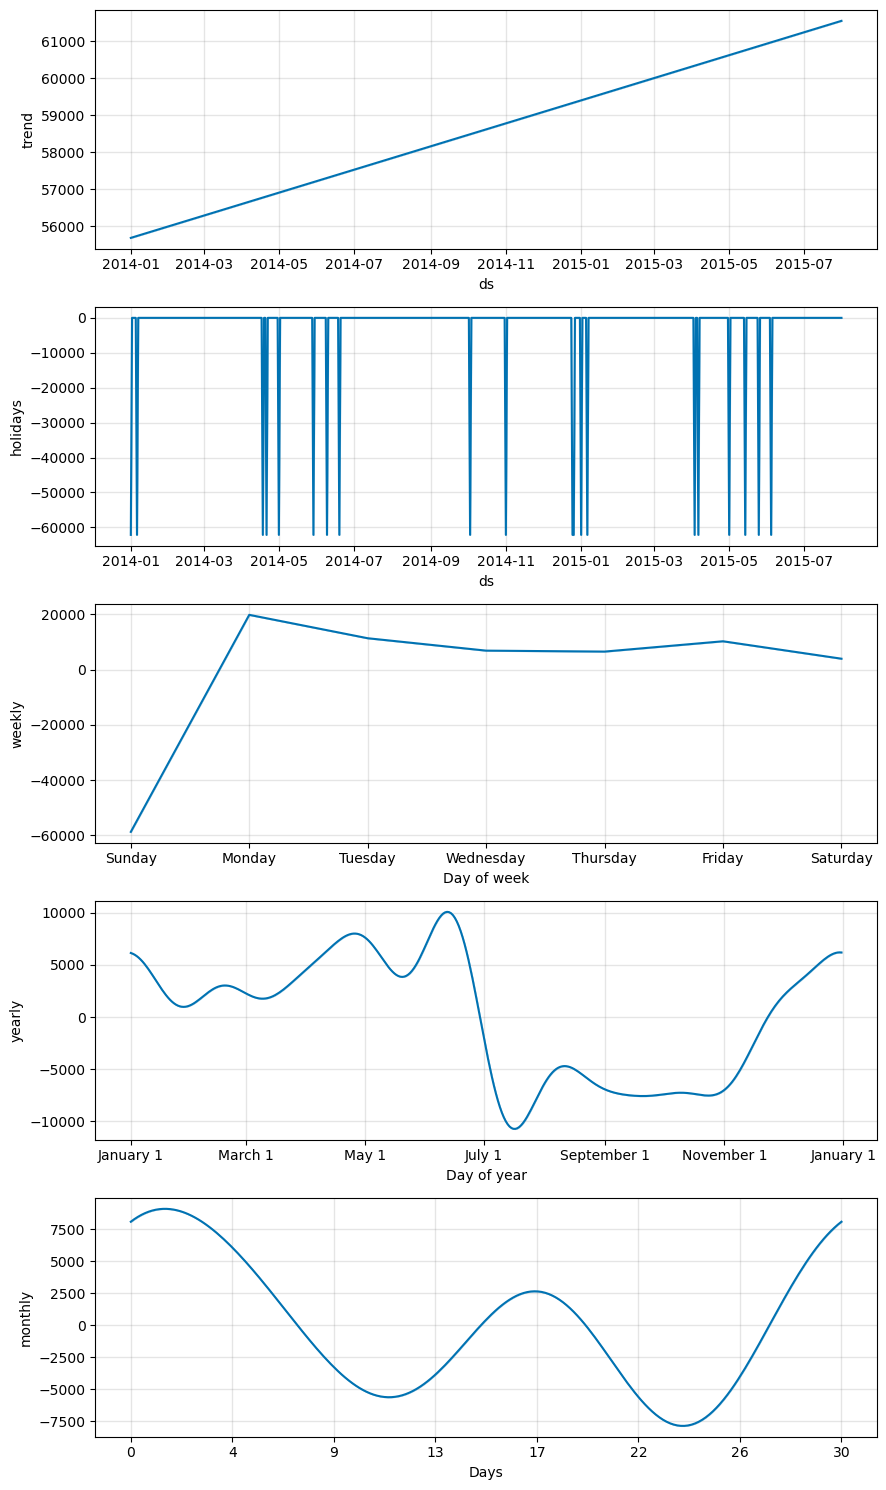

In [24]:
fig3 = m3.plot_components(forecast3)
plt.show()

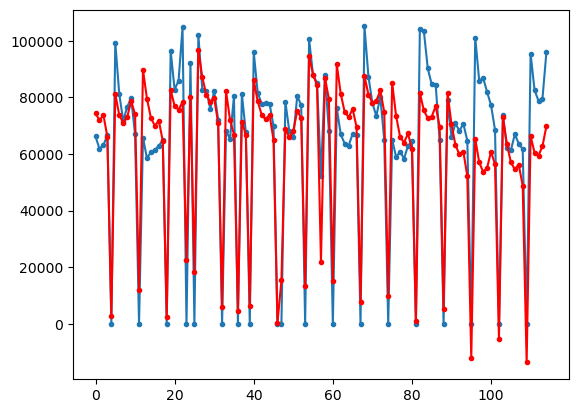

In [25]:
plt.plot(list(test['y']),'.-')
plt.plot(list(forecast3.loc[round(len(y)*0.8):,'yhat']),'r.-')
plt.show()

####  <a name="3.1.3"> **Prophet con estacionalidades custom y varias variables exogenas**</a>

In [26]:
X_promo = datos_totales_diarios['Promo']
X_promo = X_promo.reset_index(drop = False)
X_promo.columns = ['fecha', 'Promo']
X_promo.drop(X_promo.index[:365], inplace=True)
train5 = train.copy()
train5 = train5.merge(X_promo, left_on = 'ds', right_on = 'fecha', how = 'left')[['ds', 'y', 'Promo']].fillna(0)
train5.head()

,ds,y,Promo
0,2014-01-01,0,0
1,2014-01-02,68690,0
2,2014-01-03,66123,0
3,2014-01-04,61690,0
4,2014-01-05,0,0


In [27]:
holidays = pd.read_csv('../data/datos.csv')
holidays["StateHoliday"] = holidays["StateHoliday"].replace(["a", "b", "c"], 1)
holidays.drop(holidays.index[:365], inplace=True)
holidays = holidays[holidays['StateHoliday'] == 1]
holidays = holidays[['Date', 'StateHoliday']]
holidays = holidays.drop(['StateHoliday'], axis=1)
holidays['holiday'] = 'holiday'
holidays.columns = ['ds', 'holiday']
holidays.tail()

,ds,holiday
9231,2013-01-01,holiday
9232,2013-01-01,holiday
9233,2013-01-01,holiday
9234,2013-01-01,holiday
9235,2013-01-01,holiday


In [28]:
m5 = Prophet(holidays=holidays)
m5.add_regressor('Promo')
m5.add_seasonality(name='weekly', period=7, fourier_order=9)
m5.add_seasonality(name='monthly', period=30.5, fourier_order=5) 
m5.add_seasonality(name='yearly', period=365.25, fourier_order=9) 

m5.fit(train5)

future5 = m5.make_future_dataframe(periods=len(test))
future5 = future5.merge(X_promo, left_on = 'ds', right_on = 'fecha',
                        how = 'left')[['ds', 'Promo']].fillna(0)

forecast5 = m5.predict(future5)

print(r2_score(list(test['y']), list(forecast5.loc[round(len(y)*0.8):,'yhat'] )))
print(mean_absolute_error(test['y'].values, forecast5['yhat'][round(len(y)*0.8):].values))

INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


0.8872118969763982
7847.082853421755


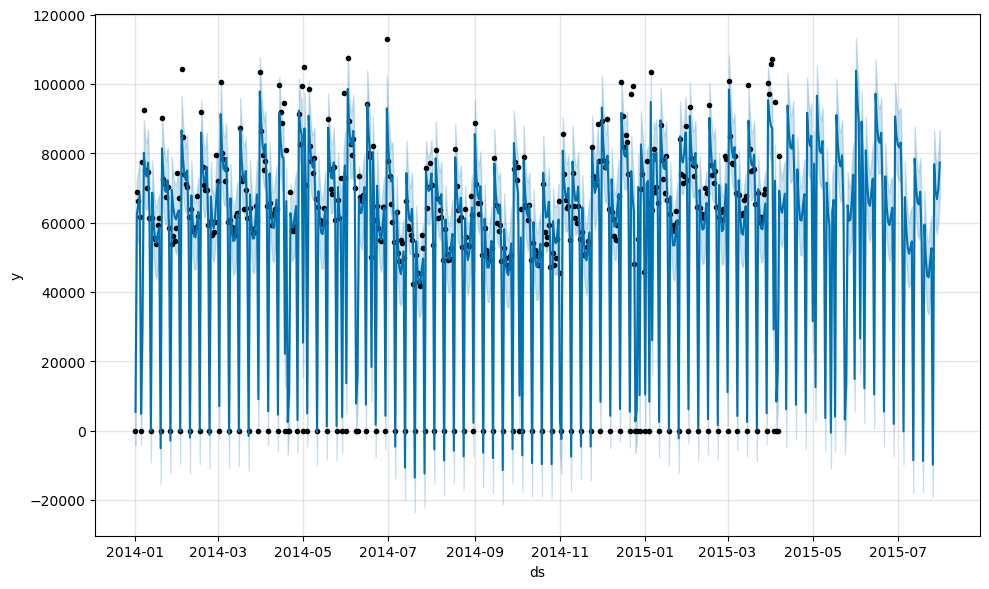

In [29]:
fig5 = m5.plot(forecast5)
plt.show()

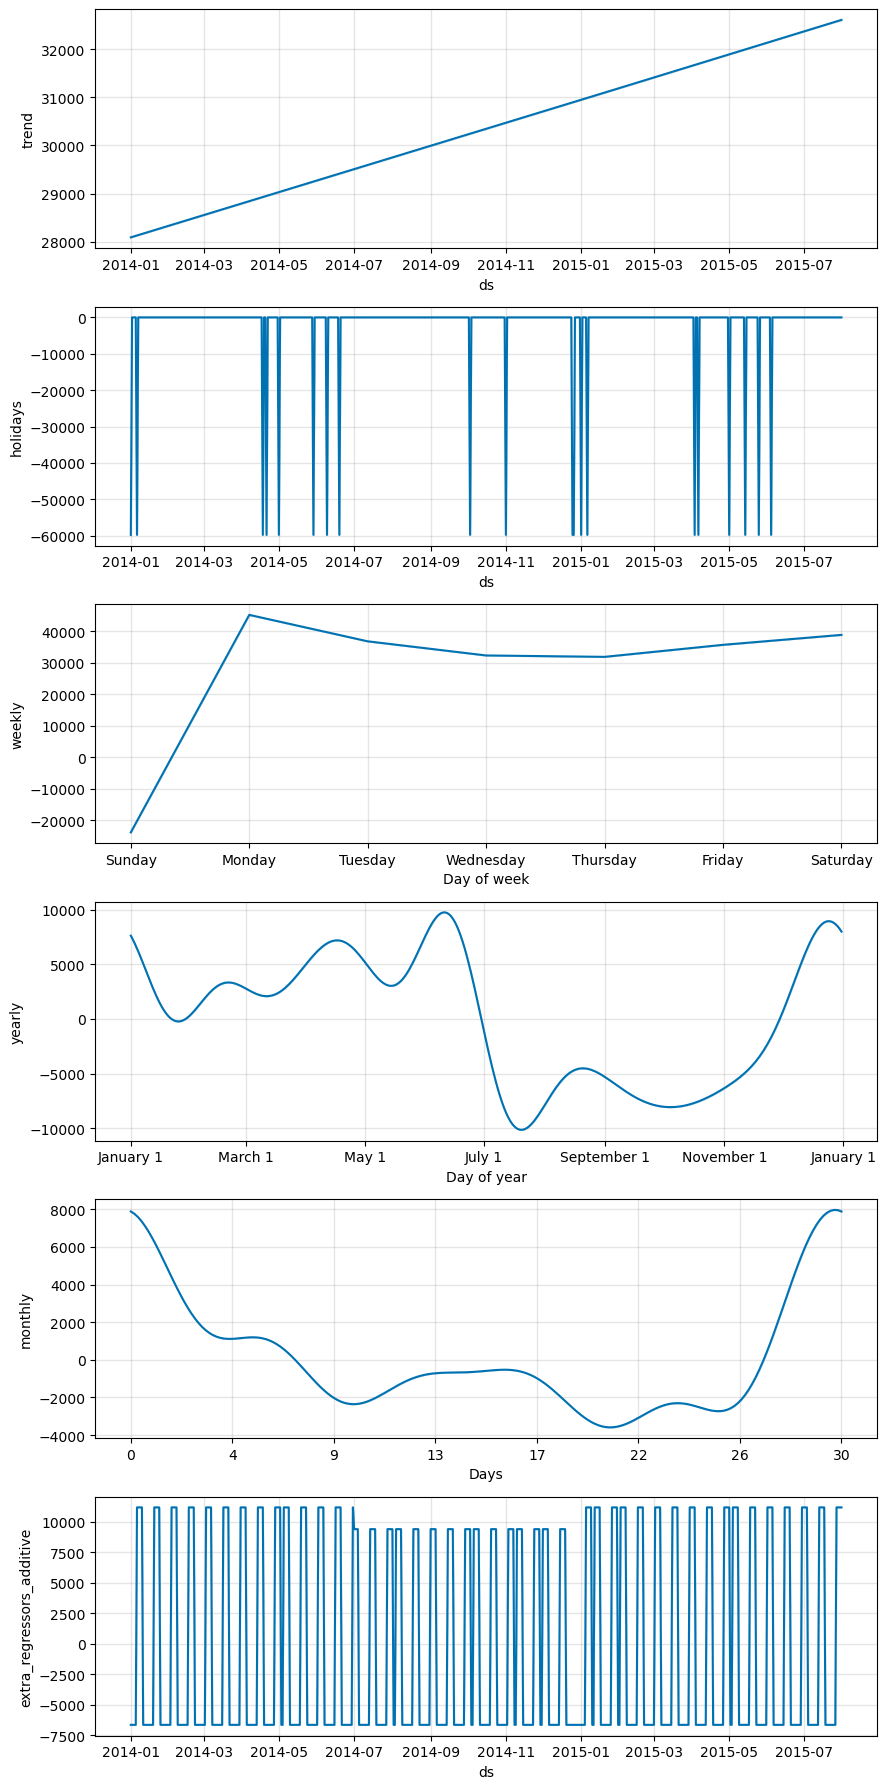

In [30]:
fig52 = m5.plot_components(forecast5)
plt.show()

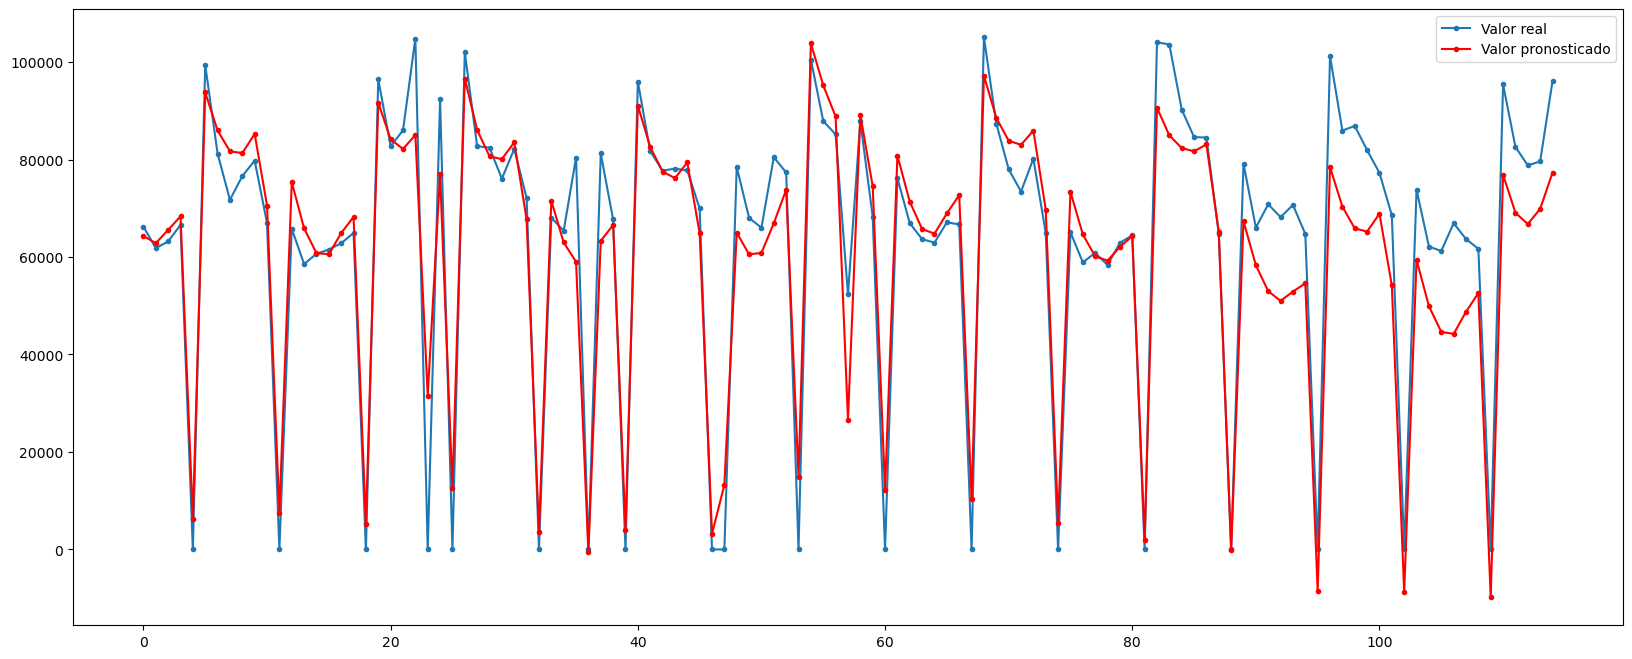

In [69]:
fig, ax = plt.subplots(figsize=(20,8))
plt.plot(list(test['y']), '.-', label='Valor real')
plt.plot(list(forecast5.loc[round(len(y)*0.8):,'yhat']),'r.-', label='Valor pronosticado')
plt.legend()
plt.show()

###  <a name="3.2"> **Neural Prophet**</a>

In [32]:
from neuralprophet import NeuralProphet, set_random_seed 
set_random_seed(0)

INFO:torch.distributed.nn.jit.instantiator:Created a temporary directory at /var/folders/qh/x1tvvd1x03xglsb7h_7v2hz00000gn/T/tmp4rs1cbkp
INFO:torch.distributed.nn.jit.instantiator:Writing /var/folders/qh/x1tvvd1x03xglsb7h_7v2hz00000gn/T/tmp4rs1cbkp/_remote_module_non_scriptable.py


In [33]:
def mean_absolute_percentage_error(y_true, y_pred):
  y_true, y_pred = np.array(y_true), np.array(y_pred)
  if np.any(y_true==0)==True:
    print('Erro: y_true contêm zeros!')
    return np.inf
  else:
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [34]:
y.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 577 entries, 0 to 576
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      577 non-null    datetime64[ns]
 1   y       577 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 9.1 KB


In [35]:
N=round(len(y)*0.8); Freq='D'
print(train.shape, test.shape)
print(train.tail(1),'\n',test.head(1))

(462, 2) (115, 2)
            ds      y
461 2015-04-07  79282 
             ds      y
462 2015-04-08  66233


In [36]:
model = NeuralProphet(
    growth="off",    # Determine trend types: 'linear', 'discontinuous', 'off'
    changepoints=None,  # list of dates that may include change points (None->automatic)
    n_changepoints=25,
    changepoints_range=0.8,
    trend_reg=0,
    trend_reg_threshold=False,
    #trend_global_local = 'local',  #me la juego
    yearly_seasonality=9,
    weekly_seasonality=7,
    daily_seasonality=False,
    seasonality_mode="additive",
    seasonality_reg=0,
    n_forecasts=1,
    n_lags=0,
    num_hidden_layers=20,
    d_hidden=3,      # Dimension of hidden layers of AR-Net
    learning_rate=0.1,
    epochs=300,  
    batch_size = 32,
    loss_func="Huber",
    normalize="minmax",   # Type of normalization ('minmax', 'standardize', 'soft', 'off')
    impute_missing=True
)

In [37]:
metrics = model.fit(train, freq=Freq)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.784% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.784% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.


Training: 0it [00:00, ?it/s]

In [38]:
future = model.make_future_dataframe(train, periods=len(test), n_historic_predictions=len(train)) 
forecast = model.predict(future)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.784% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.784% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.827% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.827% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.827% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.827% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is

Predicting: 15it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column


In [39]:
forecast

,ds,y,yhat1,trend,season_yearly,season_weekly
0,2014-01-01,0,60368.081636,-22705.908203,-3682.523682,86756.515625
1,2014-01-02,68690,56438.892626,-22705.908203,-3445.899414,82590.703125
2,2014-01-03,66123,61051.250764,-22705.908203,-3139.477539,86896.632812
3,2014-01-04,61690,58406.237101,-22705.908203,-2770.402588,83882.546875
4,2014-01-05,0,-3155.033873,-22705.908203,-2346.653076,21897.527344
...,...,...,...,...,...,...
572,2015-07-27,None,67195.610983,-22705.908203,-6841.963867,96743.484375
573,2015-07-28,None,62053.792904,-22705.908203,-6359.598633,91119.296875
574,2015-07-29,None,58180.154627,-22705.908203,-5870.456055,86756.515625
575,2015-07-30,None,54500.802718,-22705.908203,-5383.991699,82590.703125


WARNING - (NP.plotting.log_warning_deprecation_plotly) - DeprecationWarning: default plotting_backend will be changed to plotly in a future version. Switch to plotly by calling `m.set_plotting_backend('plotly')`.


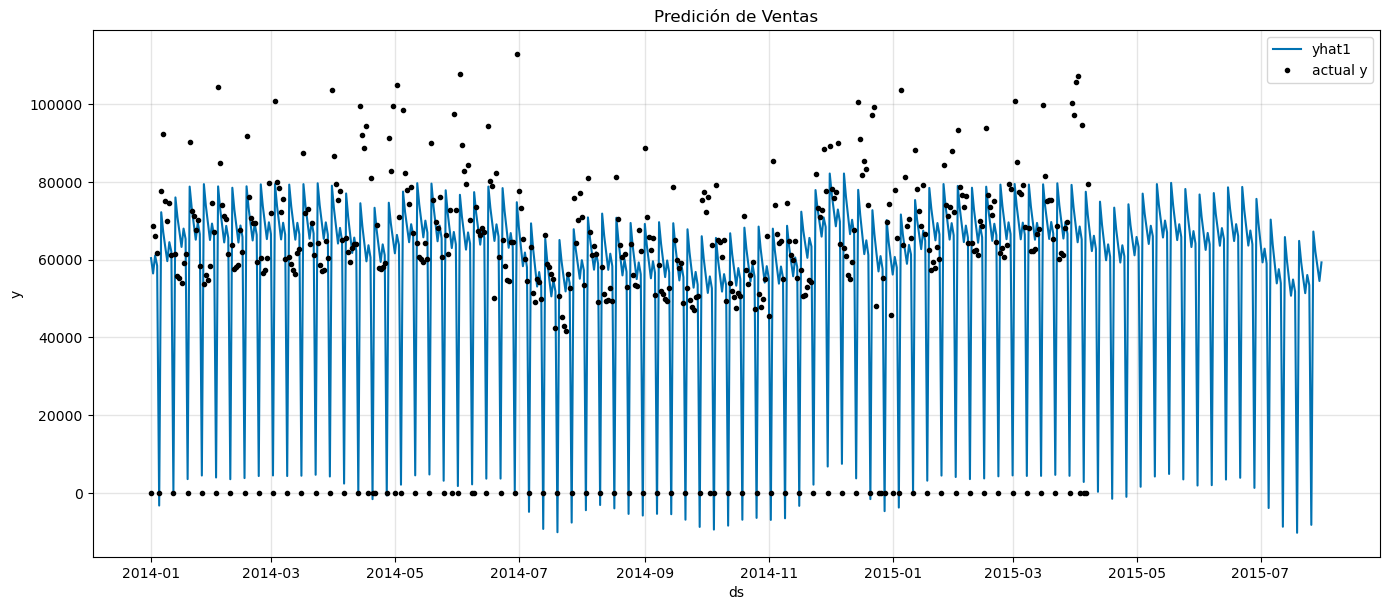

In [40]:
model.plot(forecast,figsize=(14,6))
plt.title('Predición de Ventas')
plt.show()

In [41]:
y_true = test['y'].values
y_pred = forecast['yhat1'][N:].values
mae  = mean_absolute_error(y_true, y_pred)
mape = mean_absolute_percentage_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)


print(f'MAE:  {mae:.2f} ventas')
print(f'MAPE: {mape:.2f}%')
print(f'r2: {r2:.4f}')

Erro: y_true contêm zeros!
MAE:  13104.14 ventas
MAPE: inf%
r2: 0.6247


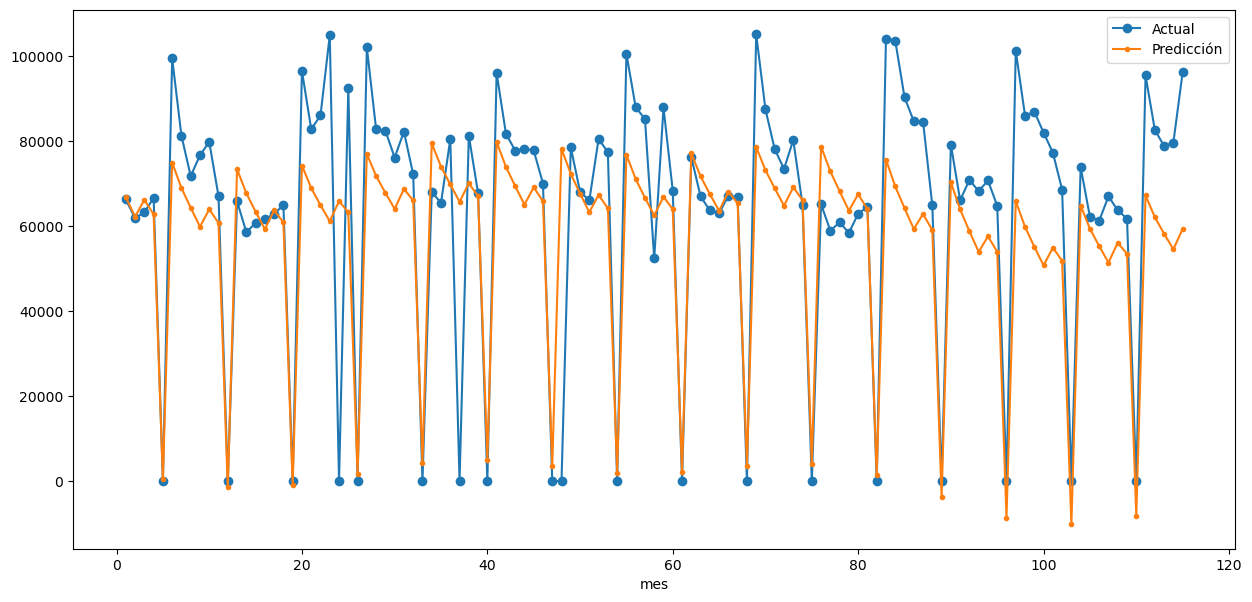

In [68]:
# plot expected vs actual
plt.figure(figsize=(15,7))
x=np.arange(1,len(y_true)+1,1)
plt.plot(x,y_true,'o-', label='Actual')
plt.plot(x,y_pred,'.-', label='Predicción')
plt.xlabel('mes')
plt.legend()
plt.show()

###  <a name="4"> **Predicción con mejor modelo y exportación de los datos**</a>

Debido a que utilizaremos todos los datos del dataset (a excepción del primer año) para el entrenamiento del modelo, volvemos a cargar los datos tanto de sales como de StateHoliday y promo.

**DATOS SALES**

In [43]:
datos = pd.read_csv('../data/datos.csv')
datos = datos.sort_values(by=['Date', 'Store'])
datos['Date'] = pd.to_datetime(datos['Date'], format=('%Y-%m-%d'))
datos.set_index('Date', inplace=True)
datos = datos.groupby('Date')['Sales', 'Open'].sum().reset_index() 
datos.set_index('Date', inplace=True)
datos.head()

,Sales,Open
Date,,
2013-01-01,0,0
2013-01-02,61926,9
2013-01-03,53588,9
2013-01-04,56578,9
2013-01-05,54938,9


In [44]:
y = datos[['Sales']]
y.drop(y.index[:365], inplace=True)
y = y.reset_index(drop=False)
y.columns = ['ds', 'y'] 
y.tail()

,ds,y
572,2015-07-27,95402
573,2015-07-28,82582
574,2015-07-29,78795
575,2015-07-30,79610
576,2015-07-31,96078


**DATOS PROMO**

In [45]:
promo = pd.read_csv('../data/datos.csv')
promo = promo.sort_values(by=['Date', 'Store'])
promo['Date'] = pd.to_datetime(promo['Date'], format=('%Y-%m-%d'))
promo.set_index('Date', inplace=True)
promo = promo.groupby('Date')['Promo'].sum().reset_index() 
promo.set_index('Date', inplace=True)
promo.head()

,Promo
Date,
2013-01-01,0
2013-01-02,0
2013-01-03,0
2013-01-04,0
2013-01-05,0


In [46]:
promo = promo.reset_index(drop = False)
promo.columns = ['fecha', 'Promo']
promo.drop(promo.index[:365], inplace=True)

from datetime import timedelta

# Create a date range for the next 41 days
end_date = promo['fecha'].max()
start_date = end_date + timedelta(days=1)
new_dates = pd.date_range(start=start_date, periods=41, freq='D')

# Create a new dataframe with the new dates
promo_fh = pd.DataFrame({'fecha': new_dates})

Tras ampliar la columna promo 41 datos mas (nuestro fh), en el caso de no ampliar los datos de promo, el modelo lo tomaría como 0s. Observando el dataset, vemos que por lo general, se aplican intermintentemente por semanas de lunes a viernes. A pesar de que no sabemos si para la predicción, este patrón de promociones continuará (en ese caso le preguntaríamos a un miembro de la empresa). Para esta predicción consideramos el inicio de las promociones la segunda semana de agosto. 


 Además, a diferencia de en 2014, en 2015 no hemos observado ningún cierre durante un largo periodo de tiempo, es por esto que entendemos que todas las tiendas estarán con promocion, por lo que los días de promoción el valor de la columna será de 10. 

In [47]:
promo_fh_predict = [0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 10, 
                    0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 10,
                    0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10]

promos_fh_predict = pd.DataFrame({'Promo': promo_fh_predict})
promo_fh = pd.concat([promo_fh, promos_fh_predict], axis=1)
promo_fh = promo.append(promo_fh, ignore_index=True)
promo_fh.tail()

,fecha,Promo
613,2015-09-06,0
614,2015-09-07,10
615,2015-09-08,10
616,2015-09-09,10
617,2015-09-10,10


In [48]:
y = y.merge(promo, left_on = 'ds', right_on = 'fecha', how = 'left')[['ds', 'y', 'Promo']].fillna(0)
y.tail()

,ds,y,Promo
572,2015-07-27,95402,10
573,2015-07-28,82582,10
574,2015-07-29,78795,10
575,2015-07-30,79610,10
576,2015-07-31,96078,10


**DATOS STATE HOLIDAY**

In [49]:
holidays = pd.read_csv('../data/datos.csv')
holidays["StateHoliday"] = holidays["StateHoliday"].replace(["a", "b", "c"], 1)
holidays.drop(holidays.index[:365], inplace=True)
holidays = holidays[holidays['StateHoliday'] == 1]
holidays = holidays[['Date', 'StateHoliday']]
holidays = holidays.drop(['StateHoliday'], axis=1)
holidays['holiday'] = 'holiday'
holidays.columns = ['ds', 'holiday']
holidays.tail()

,ds,holiday
9231,2013-01-01,holiday
9232,2013-01-01,holiday
9233,2013-01-01,holiday
9234,2013-01-01,holiday
9235,2013-01-01,holiday


In [50]:
fh = 41

In [51]:
best_model = Prophet(holidays=holidays)
best_model.add_regressor('Promo')
best_model.add_seasonality(name='weekly', period=7, fourier_order=9)
best_model.add_seasonality(name='monthly', period=30.5, fourier_order=5) 
best_model.add_seasonality(name='yearly', period=365.25, fourier_order=9) 

best_model.fit(y)

future_best = best_model.make_future_dataframe(periods=fh)
future_best = future_best.merge(promo_fh, left_on = 'ds', right_on = 'fecha', 
                                how = 'left')[['ds', 'Promo']].fillna(0)

forecast_best = best_model.predict(future_best)

INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


In [52]:
forecast_best[575:].head(10)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Promo,Promo_lower,Promo_upper,additive_terms,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
575,2015-07-30,36895.252392,69958.977671,89470.463110,36895.252392,36895.252392,11236.961359,11236.961359,11236.961359,42647.414326,...,33227.343193,33227.343193,33227.343193,-5419.093948,-5419.093948,-5419.093948,0.0,0.0,0.0,79542.666718
576,2015-07-31,36931.282043,74804.972426,94744.608017,36931.282043,36931.282043,11236.961359,11236.961359,11236.961359,48343.789085,...,36274.836520,36274.836520,36274.836520,-5445.938743,-5445.938743,-5445.938743,0.0,0.0,0.0,85275.071128
577,2015-08-01,36967.311694,61627.519318,81174.055208,36967.311694,36967.311694,-6803.457962,-6803.457962,-6803.457962,34754.448794,...,39526.523335,39526.523335,39526.523335,-5462.823900,-5462.823900,-5462.823900,0.0,0.0,0.0,71721.760488
578,2015-08-02,37003.341344,-3281.175710,16858.812275,37003.341344,37003.341344,-6803.457962,-6803.457962,-6803.457962,-29819.910718,...,-24304.829875,-24304.829875,-24304.829875,-5469.692105,-5469.692105,-5469.692105,0.0,0.0,0.0,7183.430626
579,2015-08-03,37039.370995,65799.598739,85740.482604,37039.370995,37039.370995,-6803.457962,-6803.457962,-6803.457962,38557.834720,...,46127.200882,46127.200882,46127.200882,-5466.555292,-5466.555292,-5466.555292,0.0,0.0,0.0,75597.205715
580,2015-08-04,37075.400646,54110.369883,74439.154336,37075.400646,37075.400646,-6803.457962,-6803.457962,-6803.457962,27785.805916,...,37451.906841,37451.906841,37451.906841,-5453.510156,-5453.510156,-5453.510156,0.0,0.0,0.0,64861.206562
581,2015-08-05,37111.430296,50415.712098,69935.806371,37111.430296,37111.467608,-6803.457962,-6803.457962,-6803.457962,22629.543471,...,33479.347853,33479.347853,33479.347853,-5430.752057,-5430.752057,-5430.752057,0.0,0.0,0.0,59740.973768
582,2015-08-06,37147.459947,49399.809222,69210.858278,37147.156721,37147.977488,-6803.457962,-6803.457962,-6803.457962,22123.640452,...,33227.343193,33227.343193,33227.343193,-5398.586869,-5398.586869,-5398.586869,0.0,0.0,0.0,59271.100399
583,2015-08-07,37183.489598,51855.159805,72439.330269,37182.600259,37184.421981,-6803.457962,-6803.457962,-6803.457962,25115.227182,...,36274.836520,36274.836520,36274.836520,-5357.440370,-5357.440370,-5357.440370,0.0,0.0,0.0,62298.716780
584,2015-08-08,37219.519249,55090.403849,75095.483893,37217.791185,37221.238668,-6803.457962,-6803.457962,-6803.457962,27805.601497,...,39526.523335,39526.523335,39526.523335,-5307.864835,-5307.864835,-5307.864835,0.0,0.0,0.0,65025.120746


Hardcodeamos los domingos como 0

In [53]:
predictions_daily =  forecast_best[['ds', 'yhat']].iloc[577:]
#Hardcodeamos para que los los domingos que tengan unas ventas de 0
predictions_daily['yhat'] = predictions_daily.apply(
    lambda x: 0 if x['ds'].weekday() == 6 else x['yhat'], axis=1)

In [54]:
predictions_daily.head()

,ds,yhat
577,2015-08-01,71721.760488
578,2015-08-02,0.000000
579,2015-08-03,75597.205715
580,2015-08-04,64861.206562
581,2015-08-05,59740.973768


Text(0, 0.5, 'Ventas')

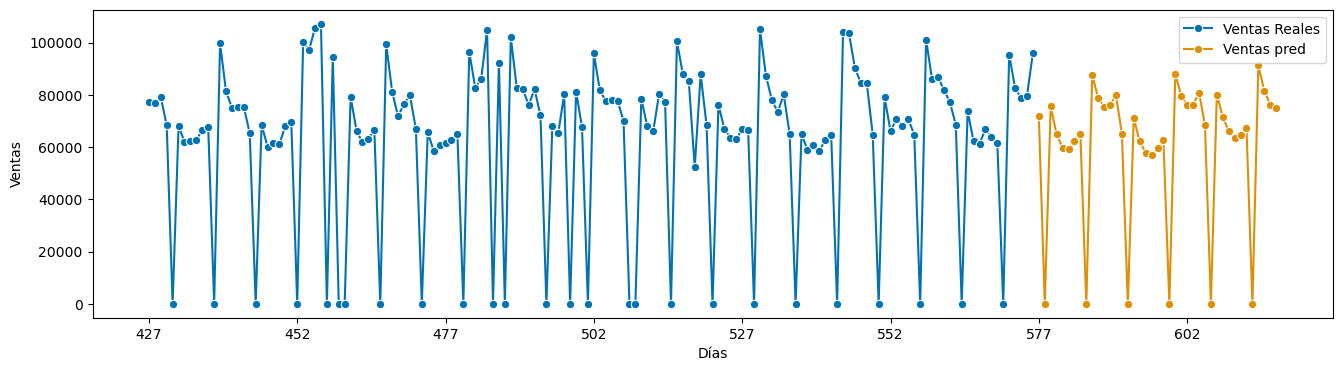

In [55]:
fig, ax = plot_series(y['y'].iloc[-150:], predictions_daily['yhat'], labels=["Ventas Reales", "Ventas pred"])
ax.legend(loc='upper right')
ax.set_xlabel('Días')
ax.set_ylabel('Ventas')

**Exportación de los datos**

In [56]:
predictions_daily[['yhat']].to_csv('../data/prediccion_diaria.csv', header=False,  index=False)

In [71]:
predictions_daily[['yhat']].to_csv('../data/prediccion_dia.csv')